In [1]:
import numpy as np
import lightgbm as lgb
from sklearn.datasets import load_sample_image
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#test data
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

a node represents a single inputs variable and a split point on that variable

Gini index

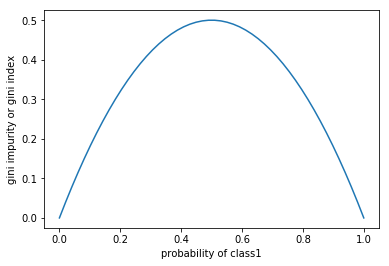

In [3]:
# binary class gini

f = lambda x: x**2
x = np.linspace(0,1,50)
x = np.array([x,1-x])
plt.plot(x[0,],1-np.sum(x**2,axis=0))
plt.xlabel('probability of class1')
plt.ylabel('gini impurity or gini index')

In [4]:
# cost function
def gini(group):
    """
    calculate gini index of a group
    group = [1,2,1,2,2]
    """
    _,counts = np.unique(group,return_counts=True)
    pcounts = counts/counts.sum()
    gini_index = 1-np.sum(pcounts**2)
    return gini_index

In [5]:
np.random.seed(1)
group =  np.random.randint(1,5,20)
group

array([2, 4, 1, 1, 4, 2, 4, 2, 4, 1, 1, 2, 1, 4, 2, 1, 3, 2, 3, 1])

In [6]:
def split(feature,value):
    """
    split the dataset based on the feature
    """
    left_mask = feature < value
    right_mask = ~left_mask
    return left_mask,right_mask

In [7]:
def split_gini(left_labels,right_labels):
    """
    calculate gini after split
    """
    counts = np.array([len(left_labels),len(right_labels)])
    weights = counts/sum(counts)
    ginis = np.array([gini(left_labels),gini(right_labels)])
    total_gini = weights.dot(ginis.T)
    return total_gini

In [85]:
def best_split(dataset,labels):
    """
    evaluatw of the splits and choose the best split
    """
    best_gini = 2
    n_features = dataset.shape[1]
    for feature_index in range(n_features):
        feature = dataset[:,feature_index]
        unique_feature_values = np.unique(feature)
        for feature_value in unique_feature_values:
            left_mask,right_mask = split(feature,feature_value)
            new_gini = split_gini(labels[left_mask],labels[right_mask])
            # print(new_gini)
            if new_gini < best_gini:
                b_feature_index,best_feature_value,best_gini,b_left,b_right =\
                feature_index,feature_value,new_gini,left_mask,right_mask
            if new_gini < 1e-5: #early return
                print('early return')
                return {'feature_index':feature_index, 'feature_value':\
            feature_value, 'left_mask':left_mask,'right_mask':right_mask,'best_gini':new_gini}
    return {'feature_index':b_feature_index, 'feature_value':\
            best_feature_value, 'left_mask':b_left,'right_mask':b_right,'best_gini':best_gini}

In [9]:
# recursive binary splitting

In [76]:
dataset = iris.data
target = iris.target

In [88]:
root = best_split(dataset,target)
root.keys()

dict_keys(['feature_index', 'feature_value', 'left_mask', 'right_mask', 'best_gini'])

# build a tree
 recursive binary splitting

1. check if it is leaf node, make a prediction
2. if not a leaf node, binary split

In [13]:
# from collections import Counter
def leaf_predict(group):
    """
    prediction of a leaf node with the most common elements
    """
    predicted = max(group, key=list(group).count)
    return predicted

In [112]:
def tree_split(node,train_set,labels,max_depth,min_size,cur_depth):
    left,right = node['left_mask'],node['right_mask']
    
    #one of child is epmty
    if not any(left) or not any(right):
        node['left_value'] = node['right_value'] = leaf_predict(labels[left|right])

    #check for max depth
    if cur_depth >= max_depth:
        node['left_value']  = leaf_predict(labels[left])
        node['right_value'] = leaf_predict(labels[right])
        
    #process left child
    if sum(left)<=min_size:
        node['left_value']  = leaf_predict(labels[left])
    else:
        child_node = best_split(train_set[left],labels[left])
        node['left'] = sub_mask(child_node['left_mask'],left) #overall_mask
        tree_split(node['left'],train_set,labels,max_depth,min_size,cur_depth+1)
    
    # process the right child
    if sum(right)<=min_size:
        node['right_value'] = leaf_predict(labels[right])
    else:
        child_node = best_split(train_set[right],labels[right])
        node['right'] = sub_mask(child_node['right_mask'],right) #overall_mask
        tree_split(node['right'],train_set,labels,max_depth,min_size,cur_depth+1)
    return node

In [15]:
def build_tree(train_set,labels, max_depth, min_leaf_size):
    tree = best_split(train_set,labels)
    cur_depth = 1
    tree_split(tree,train_set,labels,max_depth,min_leaf_size,cur_depth)
    return tree

In [124]:
root = best_split(dataset,target)

In [152]:
child = best_split(dataset[root['left_mask']],target[root['left_mask']])
parent_mask = root['left_mask']
child_node = child
child_node['left_mask'] = overall_mask(parent_mask,child_node['left_mask'])
child_node['right_mask'] = overall_mask(parent_mask,child_node['right_mask'])

early return


node 是什么？  
 - 字典
 
 树也是个字典

In [119]:
def overall_mask(mask1,mask2):
    mask3 = mask1.copy()
    mask3[mask1]= mask2
    return mask3
np.random.seed(4)
first = np.random.randn(10)>0
second = np.random.randn(len(first[first]))>0
overall_mask(first,second)

array([ True, False, False,  True, False, False, False,  True, False, False], dtype=bool)

In [109]:
def sub_mask(child_node,parent_mask):
    child_node['left_mask'] = overall_mask(parent_mask,child_node['left_mask'])
    child_node['right_mask'] = overall_mask(parent_mask,child_node['right_mask'])
    return child_node